# Analysis of Simulation Invariance to Parameter `dt`

In [35]:
# imports
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from multisim import MultiSim
from plotlabelmanager import PlotLabelManager

# set plotting style
plt.style.use(['default', 'biophysics.mplstyle'])

# define and create figure save location
fig_dir = Path('figures/dt_analysis')
fig_dir.mkdir(parents=True, exist_ok=True)

# load simulation data from data folder
multisim = MultiSim(file_dir=Path('data/tests'))

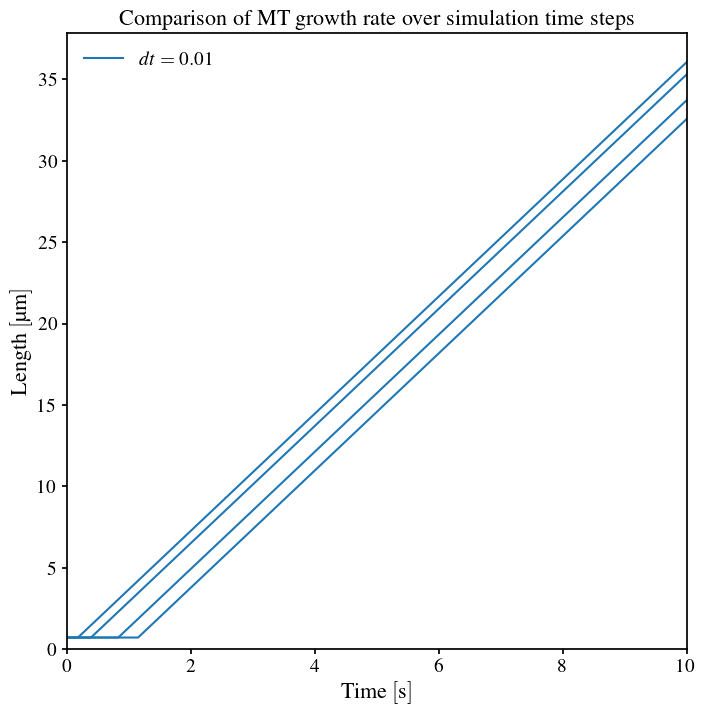

In [41]:
# make a standard MT growth over time plot labeling each simulation by the parameter dt
fig, ax = plt.subplots()

# define a label manager for the plot
plm = PlotLabelManager(
    args_map_dict={'color': list(plt.get_cmap('tab10').colors),
})

# iterate over each simulation
for sim in multisim.get_iter():
    # generate the plot label
    dt = sim.get_param('dt')
    plm.try_add(
        key=dt,
        text=f"$dt={dt}$"
    )

    # plot the time and length vectors
    ax.plot(
        sim.get_time_vec(),
        sim.get_length_vec(),
        **plm.get_args(dt),
    )

# force y-axis minimum to 0
ax.set_ylim(bottom=0)

# add axis labels and legend
ax.set_xlabel(r"Time $\left[\qty{}{\second}\right]$")
ax.set_ylabel(r"Length $\left[\qty{}{\micro\meter}\right]$")
ax.set_title("Comparison of MT growth rate over simulation time steps")
ax.legend()

# save figure
fig_name = fig_dir / "microtubule_growth"
fig.savefig(fig_name)

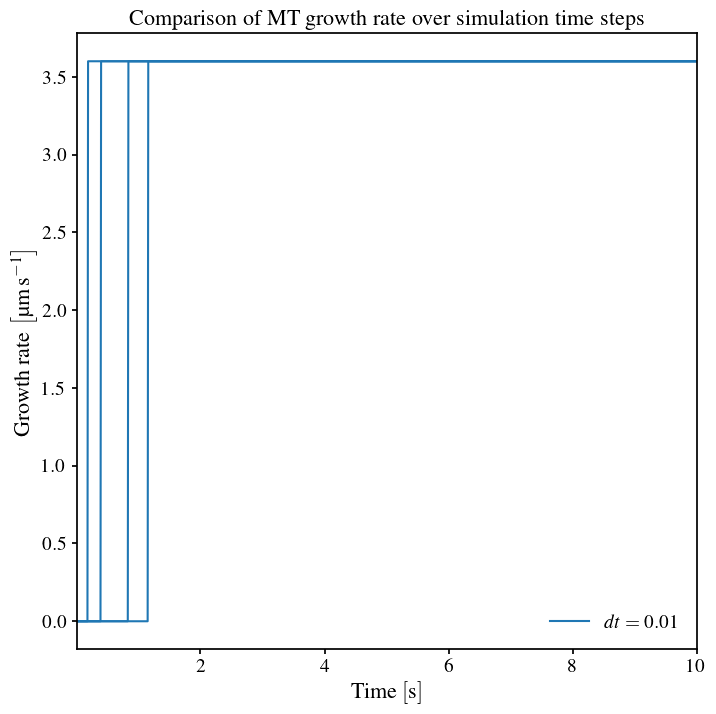

In [40]:
# make a plot of the growth rate at each step
fig, ax = plt.subplots()

# define a label manager for the plot
plm = PlotLabelManager(
    args_map_dict={'color': list(plt.get_cmap('tab10').colors),
})

# iterate over each simulation
for sim in multisim.get_iter():
    # generate the plot label
    dt = sim.get_param('dt')
    plm.try_add(
        key=dt,
        text=f"$dt={dt}$"
    )

    # calculate the growth rate
    growth_rate = np.diff(sim.get_length_vec()) / dt

    # plot the data
    ax.plot(
        sim.get_time_vec()[1:],
        growth_rate,
        **plm.get_args(dt),
    )

# add axis labels and legend
ax.set_xlabel(r"Time $\left[\qty{}{\second}\right]$")
ax.set_ylabel(r"Growth rate $\left[\qty{}{\micro\meter\per\second}\right]$")
ax.set_title("Comparison of MT growth rate over simulation time steps")
ax.legend()

# save figure
fig_name = fig_dir / "microtubule_growth_rate"
fig.savefig(fig_name)